In [217]:
# Importing the libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [218]:
dataset = pd.read_csv('../data/child_master_file.csv')

In [219]:
selectedCategoricalColumns = ['age_group','w5_best_marstt','educat','w5_geo2011','w5_best_race','w5_empl_stat',
                   'w5_hhead_gen','water_source','w5_h_enrgelec','cooking_energy','hhsize_grp','w5_h_dwltyp']

selectedNumericalColumns = ['v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109',
       'v110', 'v113', 'v116', 'v130','v132','v133','v139','v146']

target = dataset['died'].astype('int')

selectedCategories = dataset[selectedCategoricalColumns].astype('O')

selectedNumerics = dataset[selectedNumericalColumns].astype('int64','float64')

selectedDataset = selectedCategories.join(selectedNumerics, how='outer')

In [220]:
categoricals = selectedDataset.select_dtypes(include='object')
# Take k-1 dummies out of k categorical levels, drop_first set to true
categoricals = pd.get_dummies(categoricals,drop_first=True)#,drop_first=True
#numerics can be normalized separately
numerics = selectedDataset.select_dtypes(include=['int64','float64'])
selectedDataset = categoricals.join(numerics)

In [221]:
dataset = selectedDataset.join(target, how='outer')

In [222]:
def underSample_dataPrepation(df):
    #-counts the distribution of target variable
    target_count = df.died.value_counts()
    y = df.loc[:, 'died']
    X = df.iloc[:, 0:dataset.shape[1]-1]
    df_class_0 = df[df['died'] == 0]
    df_class_1 = df[df['died'] == 1]
    #-oversampling the lowest class to make it equivalent to the majority class
    df_class_0_under = df_class_0.sample(target_count[1], replace=True)
    #-concatenate the targets after oversampling
    data_train = pd.concat([df_class_1, df_class_0_under], axis=0)
    target_count_2 = data_train.died.value_counts()
    print('Class 0:', target_count_2[0])
    print('Class 1:', target_count_2[1])
    print('Proportion:', round(target_count_2[0] / target_count_2[1], 2), ': 1')
    
    x_labels = data_train.loc[:, 'died']
    x_features = data_train.iloc[:, 0:dataset.shape[1]-1]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    
    return (data_train, x_features_train, x_features_test, x_labels_train, x_labels_test)
dataset, X_train, X_test, y_train, y_test = underSample_dataPrepation(dataset)

Class 0: 149
Class 1: 149
Proportion: 1.0 : 1
length of training data
208
length of test data
90


In [223]:
X = dataset.iloc[:,:-1]
y = dataset['died'].values

In [224]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='liblinear',penalty='l2',C=1.0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [225]:
train = pd.DataFrame(X_train,columns=X.columns)
test = pd.DataFrame(X_test,columns=X.columns)

ytrain = pd.DataFrame(y_train,columns=['died'])
ytest = pd.DataFrame(y_test,columns=['died'])

train = train.join(ytrain).reset_index(drop=True)
test = test.join(ytest).reset_index(drop=True)

In [226]:
cols = [c for c in train.columns if c not in ['died']]
oof = np.zeros(len(train))
skf = StratifiedKFold(n_splits=10, random_state=42)
   
for train_index, test_index in skf.split(train.iloc[:,1:-1], train['died']):
    logit_clf = LogisticRegression()#solver='liblinear',penalty='l2',C=1.0
    logit_clf.fit(train.loc[train_index][cols].fillna(0),train.loc[train_index]['died'].fillna(0))
    oof[test_index] = logit_clf.predict_proba(train.loc[test_index][cols].fillna(0))[:,1]
    
auc = roc_auc_score(train['died'].fillna(0),oof)
print('LR without interactions scores CV =',round(auc,5))

LR without interactions scores CV = 0.5536


In [227]:
import collections
collections.Counter(y_pred)

#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
confusion

array([[26, 19],
       [16, 29]], dtype=int64)

In [228]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)
accuracy

0.6111111111111112

In [229]:
from sklearn import metrics
print("Sensitivity")
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred))
print("**********************************************")
print("Specificity")
print(TN / float(TN + FP))

Sensitivity
0.6444444444444445
0.6444444444444445
**********************************************
Specificity
0.5777777777777777


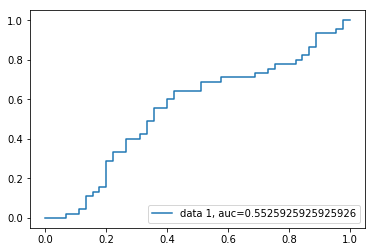

In [230]:
target_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, target_pred_proba)
auc = metrics.roc_auc_score(y_test,  target_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

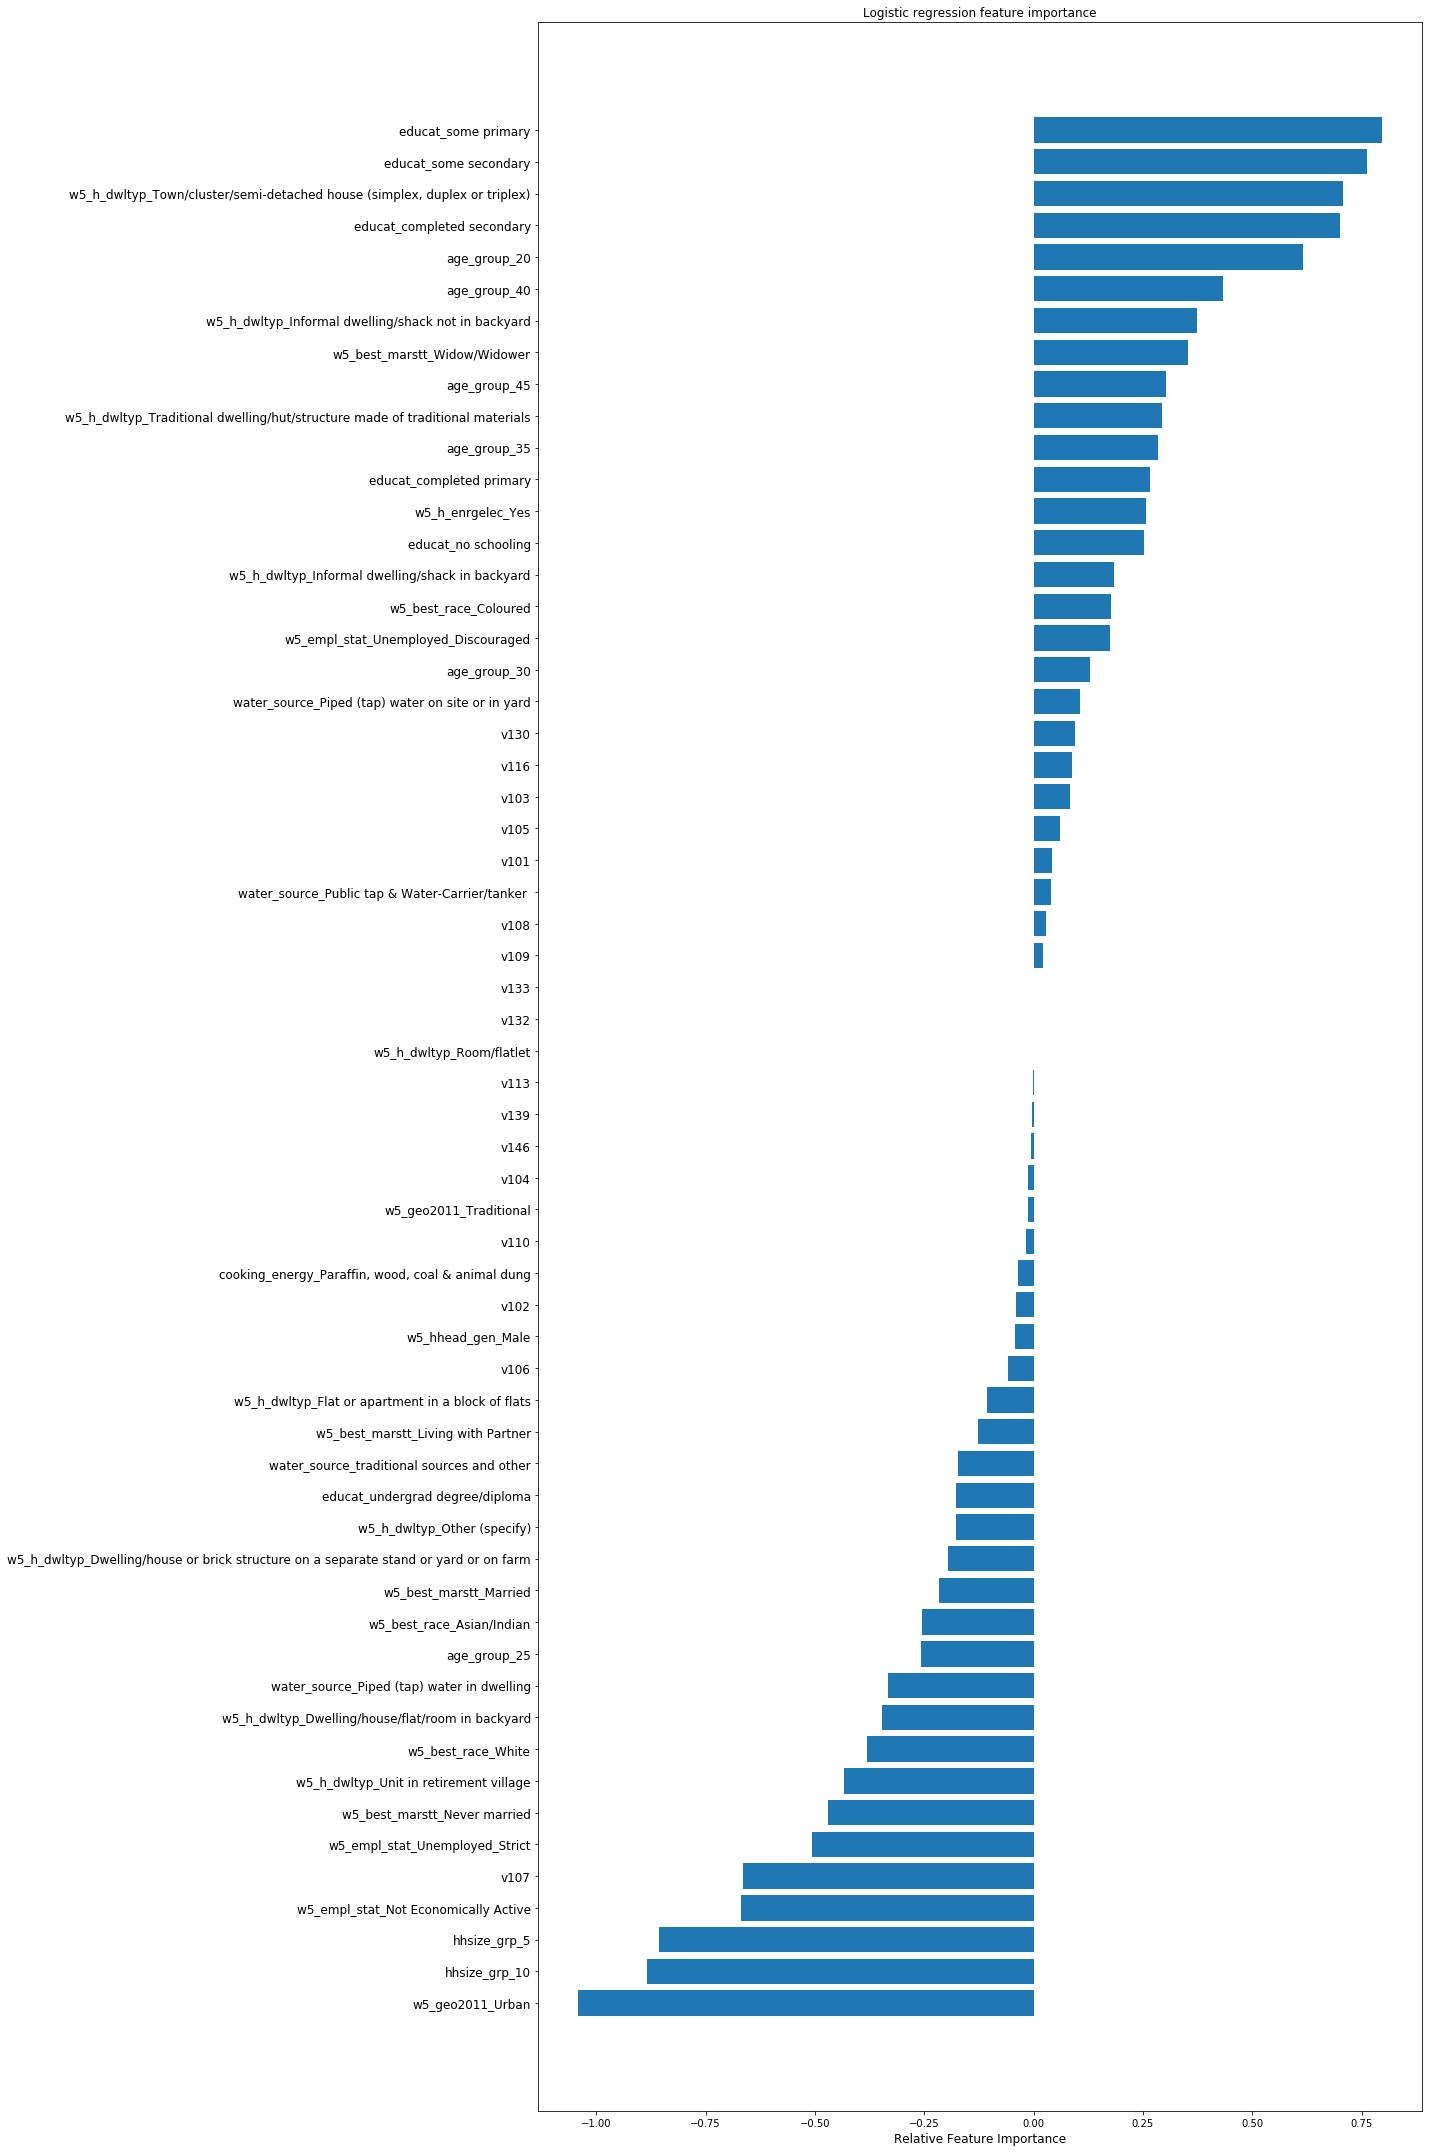

In [231]:
weights  = classifier.coef_
feature_importance = weights[0]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(20,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_title("Logistic regression feature importance")
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance', fontsize=12)
# plt.savefig('../images/logitFeatureImportance.pdf', bbox_inches='tight')
plt.tight_layout()   
plt.show()

In [232]:
odd_ratios = np.exp(classifier.coef_)
d = {'Variables': X.columns, 'weights': weights[0], 'odd ratio': odd_ratios[0], '%Change': (odd_ratios[0]-1)*100}
interpretation = pd.DataFrame(d)
interpretation

,Variables,weights,odd ratio,%Change
0,age_group_20,0.616163,1.851808,85.180814
1,age_group_25,-0.258137,0.772490,-22.751027
2,age_group_30,0.129135,1.137844,13.784393
3,age_group_35,0.285516,1.330449,33.044850
4,age_group_40,0.432980,1.541845,54.184470
5,age_group_45,0.302751,1.353578,35.357805
6,w5_best_marstt_Living with Partner,-0.126953,0.880775,-11.922483
7,w5_best_marstt_Married,-0.216336,0.805464,-19.453557
8,w5_best_marstt_Never married,-0.470022,0.624988,-37.501155
9,w5_best_marstt_Widow/Widower,0.352634,1.422810,42.280962
